<center>
<h1>Welcome to the Lab 🥼🧪</h1>
</center>

## How can we analyze supply shifts accounting for seasonality to understand which markets are over or under supplied relative to US totals?

In this notebook, we will be looking for markets that are outpacing supply growth nationwide to look for the needle in the haystack on markets changing faster than the US. 

#### What will you create in this notebook?

<p align="center">
  <img src="../../../images/tampa_market_price_drops.png" alt="Alt text">
</p>

#### Need help getting started?

As a reminder, you can get your Parcl Labs API key [here](https://dashboard.parcllabs.com/signup) to follow along.

To run this immediately, you can use Google Colab. Remember, you must set your `PARCL_LABS_API_KEY`.

Run in collab --> [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ParclLabs/parcllabs-cookbook/blob/main/examples/housing_market_research/supply_and_demand/supply_and_price_changes.ipynb)

### 1. Import the Parcl Labs Python Library

In [ ]:
# if needed, install and/or upgrade to the latest verison of the Parcl Labs Python library
%pip install --upgrade parcllabs nbformat

In [1]:
import os
import pandas as pd
from parcllabs import ParclLabsClient
from parcllabs.beta.charting.styling import SIZE_CONFIG
from parcllabs.beta.ts_stats import TimeSeriesAnalysis
from parcllabs.beta.charting.default_charts import create_dual_axis_chart

client = ParclLabsClient(
    api_key=os.environ.get('PARCL_LABS_API_KEY', "<your Parcl Labs API key if not set as environment variable>"), 
    limit=12 # set default limit
)

### 2. Search for Markets

In [3]:
# get us benchmark
metros = client.search.markets.retrieve(
    sort_by='TOTAL_POPULATION',
    sort_order='DESC',
    location_type='CBSA',
    limit=1000 # get 
)
metros

,parcl_id,country,geoid,state_fips_code,name,state_abbreviation,region,location_type,total_population,median_income,parcl_exchange_market,pricefeed_market,case_shiller_10_market,case_shiller_20_market
0,2900187,USA,35620,None,"New York-Newark-Jersey City, Ny-Nj-Pa",None,None,CBSA,19908595,93610,0,1,1,1
1,2900078,USA,31080,None,"Los Angeles-Long Beach-Anaheim, Ca",None,None,CBSA,13111917,89105,0,1,1,1
2,2899845,USA,16980,None,"Chicago-Naperville-Elgin, Il-In-Wi",None,None,CBSA,9566955,85087,0,1,1,1
3,2899734,USA,19100,None,"Dallas-Fort Worth-Arlington, Tx",None,None,CBSA,7673379,83398,0,1,0,1
4,2899967,USA,26420,None,"Houston-The Woodlands-Sugar Land, Tx",None,None,CBSA,7142603,78061,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,2900020,USA,28540,None,"Ketchikan, Ak",None,None,CBSA,13910,82763,0,0,0,0
923,2899906,USA,49820,None,"Zapata, Tx",None,None,CBSA,13896,35061,0,0,0,0
924,2899685,USA,18780,None,"Craig, Co",None,None,CBSA,13232,63983,0,0,0,0
925,2900455,USA,46900,None,"Vernon, Tx",None,None,CBSA,12795,50769,0,0,0,0


In [4]:
# Metro parcl id
metro_parcl_ids = metros['parcl_id'].tolist()

### 3. Retrieve the Data

In [6]:
# Lets get YoY changes for tampa market -- warning, you need a starter account to do this work. 
# this will pull back a lot of data and use a lot of credits. We are 
# capturing weekly supply numbers for 100 metros across the country. 

start_date='2022-09-01'

supply = client.for_sale_market_metrics.for_sale_inventory.retrieve(
    parcl_ids=metro_parcl_ids,
    start_date=start_date,
    limit=200
)

demand = client.market_metrics.housing_event_counts.retrieve(
    parcl_ids=metro_parcl_ids,
    start_date=start_date,
    limit=200
)

prices = client.market_metrics.housing_event_prices.retrieve(
    parcl_ids=metro_parcl_ids,
    start_date='2019-01-01',
    limit=200
)

price_changes = client.for_sale_market_metrics.for_sale_inventory_price_changes.retrieve(
    parcl_ids=metro_parcl_ids,
    limit=200,
    start_date=start_date
)

|████████████████████████████████████████| 927/927 [100%] in 1:18.0 (11.88/s) 
|████████████████████████████████████████| 927/927 [100%] in 4:01.6 (3.84/s) 
|████████████████████████████████████████| 927/927 [100%] in 2:15.0 (6.87/s) 


/opt/anaconda3/envs/parcllabs/lib/python3.11/site-packages/parcllabs/services/data_utils.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat(non_empty_dfs).reset_index(drop=True)


### 4. Prepare the data for analysis/charting

The algorithm:

- YTD delta between YoY Change in Demand and supply
- Peak to current within 5%
- 5 year price appreciation over 80%
- at least 40% of inventory experiencing price changes

In [46]:
# supply is a weekly series while demand is a monthly series, need to truncate supply to the month
# and then compress it to a monthly series. We will take the median value of the month to represent
# that month
supply_monthly = supply.copy(deep=True)
supply_monthly = supply_monthly.merge(price_changes[['parcl_id', 'date', 'count_price_drop']], on=['parcl_id', 'date'])
supply_monthly['pct_price_drops'] = supply_monthly['count_price_drop']/supply_monthly['for_sale_inventory']
supply_monthly['date'] = supply_monthly['date'].dt.to_period('M').dt.to_timestamp()
supply_monthly = supply_monthly.groupby(['date', 'parcl_id'])[['for_sale_inventory', 'pct_price_drops']].median().reset_index()

supply_monthly

,date,parcl_id,for_sale_inventory,pct_price_drops
0,2022-09-01,2887279,227.5,0.279625
1,2022-09-01,2887280,23500.5,0.307429
2,2022-09-01,2887281,281.5,0.232460
3,2022-09-01,2887282,18.5,0.108187
4,2022-09-01,2887283,11.5,0.309524
...,...,...,...,...
20381,2024-06-01,2900501,53.0,0.207547
20382,2024-06-01,2900502,78.0,0.289157
20383,2024-06-01,2900503,271.0,0.343284
20384,2024-06-01,2900504,156.0,0.251613


In [13]:
supply_monthly.sort_values('pct_price_drops', ascending=False)

,date,parcl_id,for_sale_inventory,pct_price_drops
10531,2024-05-01,2899906,15.0,0.633929
3363,2023-09-01,2900157,13.5,0.629121
8722,2024-03-01,2899952,31.0,0.627451
9604,2024-04-01,2899906,17.0,0.611111
4892,2023-11-01,2899826,41.5,0.609524
...,...,...,...,...
6981,2024-01-01,2900066,16.0,0.000000
7546,2024-02-01,2899699,25.0,0.000000
8720,2024-03-01,2899950,11.0,0.000000
1261,2023-07-01,2899906,19.5,0.000000


In [16]:
metros.loc[metros['parcl_id']==2899952]

,parcl_id,country,geoid,state_fips_code,name,state_abbreviation,region,location_type,total_population,median_income,parcl_exchange_market,pricefeed_market,case_shiller_10_market,case_shiller_20_market
906,2899952,USA,25820,None,"Hereford, Tx",None,None,CBSA,18585,51942,0,0,0,0


In [47]:
# now we can join with demand
data = pd.merge(demand[['date', 'parcl_id', 'sales']], supply_monthly[['date', 'parcl_id', 'for_sale_inventory']], on=['date', 'parcl_id'])
data

,date,parcl_id,sales,for_sale_inventory
0,2024-05-01,2900187,18573,27381.0
1,2024-04-01,2900187,20806,26028.0
2,2024-03-01,2900187,20148,24117.0
3,2024-02-01,2900187,18694,21852.0
4,2024-01-01,2900187,20935,16994.0
...,...,...,...,...
19454,2023-01-01,2900042,0,15.0
19455,2022-12-01,2900042,0,16.5
19456,2022-11-01,2900042,0,20.5
19457,2022-10-01,2900042,0,17.0


In [48]:
data = data.sort_values(['parcl_id', 'date'])
# Calculate percentage change in 'sales' for each 'parcl_id' over 12 periods
data['pct_change_demand'] = data.groupby('parcl_id')['sales'].pct_change(periods=12)
# Calculate percentage change in 'for_sale_inventory' for each 'parcl_id' over 12 periods
data['pct_change_supply'] = data.groupby('parcl_id')['for_sale_inventory'].pct_change(periods=12)

In [51]:
# calculate a 3 month moving average to account for spikiness in the data
data['ma_pct_change_demand'] = data.groupby('parcl_id')['pct_change_demand'].transform(lambda x: x.rolling(window=3).mean())

# Calculate a 3-month moving average for 'pct_change_supply'
data['ma_pct_change_supply'] = data.groupby('parcl_id')['pct_change_supply'].transform(lambda x: x.rolling(window=3).mean())


In [57]:
tmp = data.dropna()
tmp.head(20)

,date,parcl_id,sales,for_sale_inventory,pct_change_demand,pct_change_supply,ma_pct_change_demand,ma_pct_change_supply
4458,2023-11-01,2887279,402,419.5,0.069149,0.946636,0.001291,0.909787
4457,2023-12-01,2887279,377,368.5,-0.095923,0.609170,-0.010643,0.805152
4456,2024-01-01,2887279,341,358.0,-0.095491,0.563319,-0.040755,0.706375
4455,2024-02-01,2887279,453,459.5,0.195251,0.454114,0.001279,0.542201
4454,2024-03-01,2887279,557,510.5,0.092157,0.271482,0.063972,0.429638
4453,2024-04-01,2887279,492,554.0,0.113122,0.154167,0.133510,0.293254
4452,2024-05-01,2887279,385,573.5,-0.253876,0.113592,-0.016199,0.179747
174,2023-11-01,2887280,12382,19617.0,-0.112529,-0.113196,-0.164999,-0.141390
173,2023-12-01,2887280,13402,16985.5,-0.039283,-0.108349,-0.104251,-0.118373
172,2024-01-01,2887280,11998,15450.0,0.138222,-0.068660,-0.004530,-0.096735


In [59]:
tmp.loc[(tmp['ma_pct_change_supply']>.2) & (tmp['ma_pct_change_demand']<= -.1) & (tmp['for_sale_inventory']>100)]

,date,parcl_id,sales,for_sale_inventory,pct_change_demand,pct_change_supply,ma_pct_change_demand,ma_pct_change_supply
168,2024-05-01,2887280,11527,24153.0,-0.285989,0.320774,-0.135424,0.213481
3765,2023-11-01,2887281,708,668.5,-0.313953,1.125596,-0.280778,1.163148
3764,2023-12-01,2887281,705,576.0,-0.155689,0.975986,-0.243061,1.088832
3763,2024-01-01,2887281,823,510.0,-0.091611,0.734694,-0.187085,0.945425
13866,2023-11-01,2887283,109,117.5,0.018692,4.731707,-0.146058,6.755290
...,...,...,...,...,...,...,...,...
1831,2024-01-01,2900503,957,256.0,-0.211697,0.939394,-0.138871,0.922639
1830,2024-02-01,2900503,1006,276.0,-0.210361,0.821782,-0.173194,0.843959
1829,2024-03-01,2900503,1257,281.0,-0.284576,0.729231,-0.235545,0.830136
1828,2024-04-01,2900503,1218,297.0,-0.086957,0.850467,-0.193965,0.800493


In [95]:
tmp['test'] = tmp['ma_pct_change_demand'] - tmp['ma_pct_change_supply']
skew = tmp.loc[(tmp['for_sale_inventory']>100)&(tmp['date']=='5/1/2024')&(tmp['sales']>100)].sort_values('test', ascending=True).head(100)

/var/folders/cs/pgg3ckbn3d397n3_x2b312k80000gn/T/ipykernel_4763/446601132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['test'] = tmp['ma_pct_change_demand'] - tmp['ma_pct_change_supply']


In [75]:
supply_monthly.head()

,date,parcl_id,for_sale_inventory,pct_price_drops
0,2022-09-01,2887279,227.5,0.279625
1,2022-09-01,2887280,23500.5,0.307429
2,2022-09-01,2887281,281.5,0.232460
3,2022-09-01,2887282,18.5,0.108187
4,2022-09-01,2887283,11.5,0.309524


In [77]:
# now lets calculate the 3 month moving average on price changes
supply_monthly['ma_price_changes'] = supply_monthly.groupby('parcl_id')['pct_price_drops'].transform(lambda x: x.rolling(window=3).mean())
supply_monthly.tail()


,date,parcl_id,for_sale_inventory,pct_price_drops,ma_price_changes
20381,2024-06-01,2900501,53.0,0.207547,0.136717
20382,2024-06-01,2900502,78.0,0.289157,0.250672
20383,2024-06-01,2900503,271.0,0.343284,0.288005
20384,2024-06-01,2900504,156.0,0.251613,0.231398
20385,2024-06-01,2900505,66.0,0.200000,0.178739


In [104]:
s1 = supply_monthly.loc[(supply_monthly['ma_price_changes']>0.35) & (supply_monthly['date']=='5/1/2024')].sort_values('ma_price_changes', ascending=False)
s1 = s1.loc[s1['parcl_id'].isin(skew['parcl_id'].tolist())]

In [110]:
prices_skew = prices.loc[prices['parcl_id'].isin(skew['parcl_id'].tolist())]
prices_skew_test = prices_skew.loc[prices_skew['parcl_id']==2900128]

In [121]:
all_rows = []
for pid in prices_skew['parcl_id'].unique().tolist():
    prices_skew_test = prices_skew.loc[prices_skew['parcl_id']==pid]
    price_ts_analysis = TimeSeriesAnalysis(prices_skew_test, 'date', 'price_per_square_foot_median_sales', freq='M')
    price_rate_of_change_stats = price_ts_analysis.calculate_changes(change_since_date='3/1/2020')
    row = pd.json_normalize(price_rate_of_change_stats)
    row['parcl_id'] = pid
    all_rows.append(row)

In [200]:
ts_analysis = pd.concat(all_rows)

In [206]:
high_flyers = ts_analysis.loc[(ts_analysis['peak_to_current.percent_change'] > -.05) & (ts_analysis['change_since_date.percent_change']>.5)]
hf = high_flyers.loc[high_flyers['parcl_id'].isin(s1.loc[s1['for_sale_inventory']>1000]['parcl_id'].tolist())]

In [195]:
ts_analysis.loc[ts_analysis['parcl_id']==2899822]

,1_month.value_diff,1_month.percent_change,3_month.value_diff,3_month.percent_change,6_month.value_diff,6_month.percent_change,12_month.value_diff,12_month.percent_change,2_year.value_diff,2_year.percent_change,...,52_week_high.value,52_week_high.date,52_week_low.value,52_week_low.date,change_since_date.value_diff,change_since_date.percent_change,change_since_date.change_date,change_since_date.change_value,parcl_id,name
8,-4.05,-0.0178,-1.87,-0.0083,1.92,0.0086,-6.31,-0.0274,4.71,0.0215,...,228.51,2023-06-01,214.85,2023-10-01,81.61,0.5728,2020-03-01,142.47,2899822,"Cape Coral-Fort Myers, Fl"


In [208]:
import plotly.express as px

# Ensure 'parcl_id' is treated as a categorical variable by converting to string
hf = high_flyers.loc[high_flyers['parcl_id'].isin(s1.loc[s1['for_sale_inventory']>1000]['parcl_id'].tolist())]
hf = pd.merge(hf, metros[['parcl_id', 'name']], on='parcl_id')

# Sort the DataFrame based on 'change_since_date.percent_change'
ts_analysis_sorted = hf.sort_values('change_since_date.percent_change')

# Create an interactive bar chart
fig = px.bar(ts_analysis_sorted, x='name', y='change_since_date.percent_change',
             labels={'parcl_id': 'Parcel ID', 'change_since_date.percent_change': 'Percent Change'},
             title='Percent Change by Parcel ID',
             category_orders={'parcl_id': ts_analysis_sorted['parcl_id'].tolist()})  # This ensures the sorting order is preserved in the plot

fig.show()


In [211]:
hf_ids = hf['parcl_id'].unique().tolist()
zzz = skew.loc[skew['parcl_id'].isin(hf_ids)].merge(metros[['parcl_id', 'name']], on='parcl_id')
zzz['demand_ratio'] = zzz['for_sale_inventory']/zzz['sales']
zzz

,date,parcl_id,sales,for_sale_inventory,pct_change_demand,pct_change_supply,ma_pct_change_demand,ma_pct_change_supply,test,name,demand_ratio
0,2024-05-01,2900354,504,1862.0,-0.514451,0.386448,-0.315879,0.378819,-0.694699,"Sebastian-Vero Beach, Fl",3.694444
1,2024-05-01,2900268,1668,5028.5,-0.339929,0.404217,-0.231927,0.398934,-0.630860,"Port St. Lucie, Fl",3.014688
2,2024-05-01,2900021,302,1172.0,-0.382413,0.358053,-0.185886,0.443093,-0.628979,"Key West, Fl",3.880795
3,2024-05-01,2899729,1076,3962.0,-0.321991,0.374263,-0.235234,0.356438,-0.591672,"Crestview-Fort Walton Beach-Destin, Fl",3.682156
4,2024-05-01,2900173,2558,5771.5,-0.112114,0.365712,-0.141620,0.442202,-0.583823,"Naples-Marco Island, Fl",2.256255
5,2024-05-01,2899748,2493,6909.0,-0.341173,0.361111,-0.217588,0.358934,-0.576522,"Deltona-Daytona Beach-Ormond Beach, Fl",2.771360
6,2024-05-01,2900041,2235,5614.0,-0.294953,0.412682,-0.188959,0.383816,-0.572775,"Lakeland-Winter Haven, Fl",2.511857
7,2024-05-01,2900229,2139,5070.5,-0.295918,0.409647,-0.178310,0.391494,-0.569804,"Palm Bay-Melbourne-Titusville, Fl",2.370500
8,2024-05-01,2899822,5757,10645.0,-0.038898,0.406023,-0.047012,0.512647,-0.559659,"Cape Coral-Fort Myers, Fl",1.849053
9,2024-05-01,2900417,9288,22462.5,-0.275451,0.406279,-0.155309,0.373752,-0.529060,"Tampa-St. Petersburg-Clearwater, Fl",2.418443


In [210]:
zz = s1.loc[s1['parcl_id'].isin(hf_ids)].merge(metros[['parcl_id', 'name']], on='parcl_id')
zz.loc[zz['for_sale_inventory']>1000]

,date,parcl_id,for_sale_inventory,pct_price_drops,ma_price_changes,name
0,2024-05-01,2899822,10645.0,0.489137,0.492953,"Cape Coral-Fort Myers, Fl"
1,2024-05-01,2900173,5771.5,0.499319,0.488775,"Naples-Marco Island, Fl"
2,2024-05-01,2900417,22462.5,0.451207,0.446891,"Tampa-St. Petersburg-Clearwater, Fl"
3,2024-05-01,2900021,1172.0,0.445785,0.441276,"Key West, Fl"
4,2024-05-01,2900268,5028.5,0.413966,0.422495,"Port St. Lucie, Fl"
5,2024-05-01,2900354,1862.0,0.413841,0.412941,"Sebastian-Vero Beach, Fl"
6,2024-05-01,2900229,5070.5,0.403343,0.404745,"Palm Bay-Melbourne-Titusville, Fl"
7,2024-05-01,2899748,6909.0,0.423590,0.404032,"Deltona-Daytona Beach-Ormond Beach, Fl"
8,2024-05-01,2900041,5614.0,0.394804,0.400548,"Lakeland-Winter Haven, Fl"
9,2024-05-01,2899961,1672.5,0.393461,0.393875,"Homosassa Springs, Fl"


<Axes: xlabel='date'>

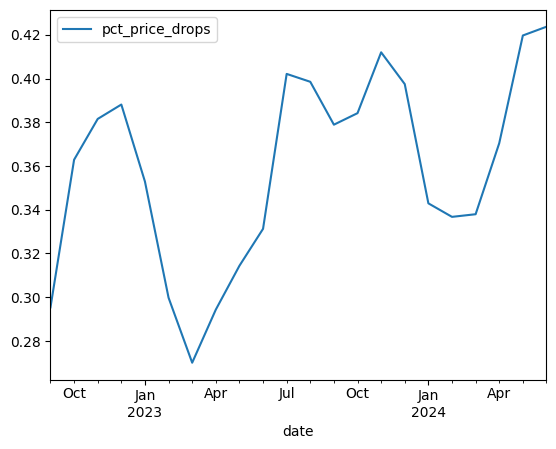

In [189]:
ex_id = 2899729
supply_monthly.loc[supply_monthly['parcl_id']==ex_id].plot(x='date', y='pct_price_drops')

<Axes: xlabel='date'>

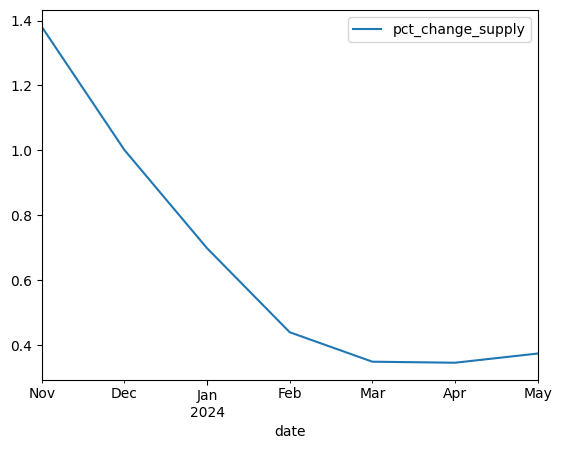

In [190]:
tmp.loc[tmp['parcl_id']==ex_id].plot(x='date', y='pct_change_supply')

<Axes: xlabel='date'>

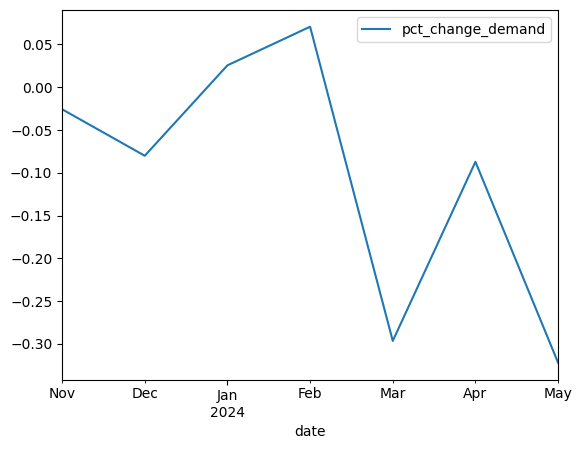

In [191]:
tmp.loc[tmp['parcl_id']==ex_id].plot(x='date', y='pct_change_demand')

### 5. Chart the Data

In [192]:
import pandas as pd
import plotly.graph_objects as go

from parcllabs.beta.charting.styling import default_style_config
from parcllabs.beta.charting.utils import create_labs_logo_dict, save_figure, sort_chart_data

def create_yoy_comparison_chart(
    title: str,
    line1_data: pd.DataFrame,
    line1_series: str,
    line2_data: pd.DataFrame,
    line2_series: str,
    save_path: str = None,
    yaxis_title: str = 'Year-over-Year % Change',
    height=675,
    width=1200,
    style_config=default_style_config
):
    fig = go.Figure()

    # Sort the data
    line1_data = sort_chart_data(line1_data)
    line2_data = sort_chart_data(line2_data)

    # Multiply the series values by 100 and round to 2 decimal points
    line1_data[line1_series] = (line1_data[line1_series] * 100).round(2)
    line2_data[line2_series] = (line2_data[line2_series] * 100).round(2)

    # Add the first line series
    fig.add_trace(go.Scatter(
        x=line1_data['date'],
        y=line1_data[line1_series],
        mode='lines+markers',
        line=dict(width=style_config['line_width'], color=style_config['line_color']),
        marker=dict(size=style_config['marker_size'], color=style_config['marker_color'], line=dict(width=1, color=style_config['marker_outline_color'])),
        name=line1_series
    ))

    # Add the second line series
    fig.add_trace(go.Scatter(
        x=line2_data['date'],
        y=line2_data[line2_series],
        mode='lines+markers',
        line=dict(width=style_config['line_width'], color=style_config['line2_color']),
        marker=dict(size=style_config['marker_size'], color=style_config['marker2_color'], line=dict(width=1, color=style_config['marker2_outline_color'])),
        name=line2_series
    ))

    fig.update_layout(
        margin=dict(l=40, r=40, t=80, b=40),
        height=height,
        width=width,
        title={
            'text': title,
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': style_config['title_font'],
        },
        plot_bgcolor=style_config['background_color'],
        paper_bgcolor=style_config['background_color'],
        font=dict(color=style_config['font_color']),
        xaxis=dict(
            title_text='',
            showgrid=style_config['showgrid'],
            gridwidth=style_config['gridwidth'],
            gridcolor=style_config['grid_color'],
            tickangle=style_config['tick_angle'],
            tickfont=style_config['axis_font'],
            linecolor=style_config['line_color_axis'],
            linewidth=style_config['linewidth'],
            titlefont=style_config['title_font_axis']
        ),
        yaxis=dict(
            title_text=yaxis_title,
            showgrid=style_config['showgrid'],
            gridwidth=style_config['gridwidth'],
            gridcolor=style_config['grid_color'],
            tickfont=style_config['axis_font'],
            tickprefix='',
            ticksuffix='%',
            zeroline=False,
            linecolor=style_config['line_color_axis'],
            linewidth=style_config['linewidth'],
            titlefont=style_config['title_font_axis']
        ),
        hovermode='x unified',
        hoverlabel=dict(
            bgcolor=style_config['hover_bg_color'],
            font_size=style_config['hover_font_size'],
            font_family=style_config['hover_font_family'],
            font_color=style_config['hover_font_color']
        ),
        legend=dict(
            x=style_config['legend_x'],
            y=style_config['legend_y'],
            xanchor=style_config['legend_xanchor'],
            yanchor=style_config['legend_yanchor'],
            font=style_config['legend_font'],
            bgcolor='rgba(0, 0, 0, 0)'
        ),
    )

    fig.add_layout_image(
        create_labs_logo_dict()
    )

    save_figure(fig, save_path=save_path, width=width, height=height)

    fig.show()

# Update style configuration for second line
default_style_config['line2_color'] = 'green'
default_style_config['marker2_color'] = 'green'
default_style_config['marker2_outline_color'] = 'green'
default_style_config['line_color'] = 'red'
default_style_config['marker_color'] = 'red'
default_style_config['marker_outline_color'] = 'red'

chart_data = tmp.loc[tmp['parcl_id']==ex_id].dropna()
chart_data = chart_data.loc[chart_data['date']>='1/1/2024']
name = metros.loc[metros['parcl_id']==ex_id]['name'].values[0]

chart_data = chart_data.rename(columns={'pct_change_demand': 'YoY Change in Demand', 'pct_change_supply': 'YoY Change in Supply'})

# Create the chart
create_yoy_comparison_chart(
    title=f'{name} Metro: YoY Changes in Supply & Demand',
    line1_data=chart_data,
    line1_series='YoY Change in Demand',
    line2_data=chart_data,
    line2_series='YoY Change in Supply',
    save_path=None,
    style_config=default_style_config
)
